# Supplementary materials : Details on generating Figure 2

This document is a supplementary material of the article *Detecting periodicities with Gaussian
processes* by N. Durrande, J. Hensman, M. Rattray and N. D. Lawrence. 

The first step is to import the required packages. This tutorial has been written with GPy 0.8.8 which includes the kernels discussed in the article. The latter can be downloaded on the [SheffieldML github page](https://github.com/SheffieldML/GPy). 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

np.random.seed(1)

warning in stationary: failed to import cython module: falling back to numpy


The boundary limits for the plots are set to $[0,4 \pi]$, and we consider a period of $2 \pi$ :

In [2]:
class AperiodicMatern32(GPy.kern.Kern):
    """
    Kernel of the aperiodic subspace (up to a given frequency) of a Matern 3/2 RKHS.

    Only defined for input_dim=1.
    """

    def __init__(self, input_dim=1, variance=1., lengthscale=1., period=2.*np.pi,
            n_freq=10, lower=0., upper=4*np.pi,
            active_dims=None, name='aperiodic_Matern32'):
        self.per_kern = GPy.kern.PeriodicMatern32(input_dim, variance, lengthscale, period, n_freq, lower, upper, active_dims, name='dummy kernel')
        self.whole_kern = GPy.kern.Matern32(input_dim, variance, lengthscale, name='dummy kernel')
        GPy.kern.Kern.__init__(self, input_dim, active_dims, name)

        self.variance = GPy.core.Param('variance', np.float64(variance), GPy.core.parameterization.transformations.Logexp())
        self.lengthscale = GPy.core.Param('lengthscale', np.float64(lengthscale), GPy.core.parameterization.transformations.Logexp())
        self.period = GPy.core.Param('period', np.float64(period), GPy.core.parameterization.transformations.Logexp())
        self.link_parameters(self.variance, self.lengthscale, self.period)


    def parameters_changed(self):
        self.whole_kern.variance = self.variance * 1.
        self.per_kern.variance = self.variance * 1.

        self.whole_kern.lengthscale = self.lengthscale * 1.
        self.per_kern.lengthscale = self.lengthscale * 1.

        self.per_kern.period = self.period * 1.
    
    def K(self, X, X2=None):
        return self.whole_kern.K(X, X2) - self.per_kern.K(X, X2)

    def Kdiag(self, X):
        return np.diag(self.K(X))

    def update_gradients_full(self, dL_dK, X, X2=None):
        self.whole_kern.update_gradients_full(dL_dK, X, X2)
        self.per_kern.update_gradients_full(-dL_dK, X, X2)
        self.variance.gradient = self.whole_kern.variance.gradient + self.per_kern.variance.gradient
        self.lengthscale.gradient = self.whole_kern.lengthscale.gradient + self.per_kern.lengthscale.gradient
        self.period.gradient = self.per_kern.period.gradient



In [3]:
# Domain Parameters
a = 0.            # lower bound of the space
b = 4*np.pi       # upper bound

# kernel parameters
per = 2*np.pi     # period
var = 1.          # variance
N = 20            # max frequency in the decomposition (the number of basis functions is 2N)

We know from the article that a Matérn kernels $k$ can be decomposed as a sum of a periodic and aperiodic kernel : $k=k_p+k_a$. In the code below, we consider 3 Matérn 3/2 kernels km1, km2, km3 with various lengthscales and we denote by kp[123] and ka[123] their associated periodic and aperiodic components.

In [4]:
lenscl=.5
km1 = GPy.kern.Matern32(input_dim=1,variance=var,lengthscale=lenscl)
kp1 = GPy.kern.PeriodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)
ka1 = AperiodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)

lenscl=2.
km2 = GPy.kern.Matern32(input_dim=1,variance=var,lengthscale=lenscl)
kp2 = GPy.kern.PeriodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)
ka2 = AperiodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)

lenscl=5.
km3 = GPy.kern.Matern32(input_dim=1,variance=var,lengthscale=lenscl)
kp3 = GPy.kern.PeriodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)
ka3 = AperiodicMatern32(input_dim=1, variance=var, lengthscale=lenscl, period=per, n_freq=N, lower=a, upper=b)


**Subfigure a: Matern 3/2 kernel $k$**

(-0.1, 1.1)

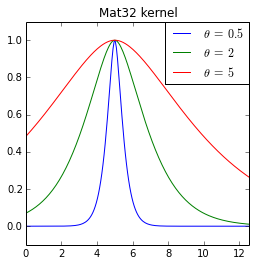

In [5]:
x = 5.
fig = plt.figure(figsize=(4,4))
km1.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b-')
km2.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b--')
km3.plot(x,plot_limits=[a,b], fignum=fig.number)
plt.xlabel('')
plt.ylabel('')
plt.legend(["$\\theta\  =\  0.5$","$\\theta \ = \ 2$","$\\theta \ = \ 5$"],prop={'size':12},borderaxespad=0.)
plt.ylim([-0.1,1.1])


**Subfigure b: periodic sub-kernel $k_p$**

(-0.13, 0.42)

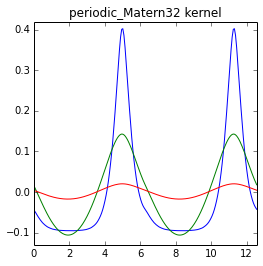

In [6]:
fig = plt.figure(figsize=(4,4))
kp1.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b-')
kp2.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b--')
kp3.plot(x,plot_limits=[a,b], fignum=fig.number)
plt.xlabel('')
plt.ylabel('')
#plt.legend(["$\\theta\  =\  0.5$","$\\theta \ = \ 2$","$\\theta \ = \ 5$"],prop={'size':12},borderaxespad=0.)
plt.ylim([-0.13,0.42])

**Subfigure c: aperiodic sub-kernel $k_a$**

(-0.45, 1.05)

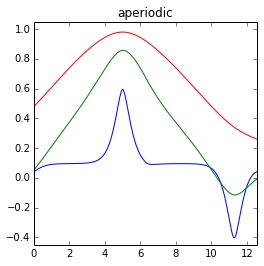

In [7]:
fig = plt.figure(figsize=(4,4))
ka1.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b-')
ka2.plot(x,plot_limits=[a,b], fignum=fig.number)#, 'all', None,'b--')
ka3.plot(x,plot_limits=[a,b], fignum=fig.number)
plt.xlabel('')
plt.ylabel('')
plt.title('aperiodic')
#plt.legend(["$\\theta\  =\  0.5$","$\\theta \ = \ 2$","$\\theta \ = \ 5$"],prop={'size':12},borderaxespad=0.)
plt.ylim([-0.45,1.05])
